## PPO

In [40]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
import time
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict, Optional, Union, Tuple
from flax.training.train_state import TrainState
import distrax
import gymnax
import functools
from functools import partial
from gymnax.environments import environment, spaces
import chex
import wandb
from flax import struct


class GymnaxWrapper(object):
    """Base class for Gymnax wrappers."""

    def __init__(self, env):
        self._env = env
    
    # provide proxy access to regular attributes of wrapped object
    def __getattr__(self, name):
        return getattr(self._env, name)

@struct.dataclass
class LogEnvState:
    env_state: environment.EnvState
    episode_returns: float
    episode_lengths: int
    returned_episode_returns: float
    returned_episode_lengths: int
    timestep: int

class LogWrapper(GymnaxWrapper):
    """Log the episode returns and lengths."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, env_state = self._env.reset(key, params)
        state = LogEnvState(env_state, 0, 0, 0, 0, 0)
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, env_state, reward, done, info = self._env.step(key, state.env_state, action, params)
        new_episode_return = state.episode_returns + reward
        new_episode_length = state.episode_lengths + 1
        state = LogEnvState(
            env_state = env_state,
            episode_returns = new_episode_return * (1 - done),
            episode_lengths = new_episode_length * (1 - done),
            returned_episode_returns = state.returned_episode_returns * (1 - done) + new_episode_return * done,
            returned_episode_lengths = state.returned_episode_lengths * (1 - done) + new_episode_length * done,
            timestep = state.timestep + 1,
        )
        info["returned_episode"] = done
        info["return_info"] = jnp.stack([state.timestep, state.returned_episode_returns])
        return obs, state, reward, done, info

class ScannedRNN(nn.Module):

  @functools.partial(
    nn.scan,
    variable_broadcast='params',
    in_axes=0,
    out_axes=0,
    split_rngs={'params': False})
  @nn.compact
  def __call__(self, carry, x):
    """Applies the module."""
    features = carry[0].shape[-1]
    rnn_state = carry
    ins, resets = x
    rnn_state = jnp.where(resets[:, np.newaxis], self.initialize_carry(ins.shape[0], ins.shape[1]), rnn_state)
    new_rnn_state, y = nn.GRUCell(features)(rnn_state, ins)
    return new_rnn_state, y

  @staticmethod
  def initialize_carry(batch_size, hidden_size):
    return nn.GRUCell(hidden_size, parent=None).initialize_carry(
        jax.random.PRNGKey(0), (batch_size, hidden_size))

class ActorCriticRNN(nn.Module):
    action_dim: Sequence[int]
    config: Dict

    @nn.compact
    def __call__(self, hidden, x):
        obs, dones = x
        embedding = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(obs)
        embedding = nn.leaky_relu(embedding)
        embedding = nn.Dense(256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(embedding)
        embedding = nn.leaky_relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        actor_mean = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(embedding)
        actor_mean = nn.leaky_relu(actor_mean)
        actor_mean = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(actor_mean)
        actor_mean = nn.leaky_relu(actor_mean)
        actor_mean = nn.Dense(self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0))(actor_mean)
        if self.config["CONTINUOUS"]:
            actor_logtstd = self.param('log_std', nn.initializers.zeros, (self.action_dim,))
            pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))
        else:
            pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(embedding)
        critic = nn.leaky_relu(critic)
        critic = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(critic)
        critic = nn.leaky_relu(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(critic)

        return hidden, pi, jnp.squeeze(critic, axis=-1)

    @staticmethod
    def initialize_carry(batch_size, hidden_size):
        return nn.GRUCell(hidden_size, parent=None).initialize_carry(
            jax.random.PRNGKey(0), (batch_size, hidden_size))

class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    if "ENV_NAME" not in config:
        env, env_params = config["ENV"], config["ENV_PARAMS"]
        env = LogWrapper(env)
    else:
        env, env_params = gymnax.make(config["ENV_NAME"])
        env = LogWrapper(env)

    if "MOD_ENV_PARAMS" in config:
        env_params = env_params.replace(**config["MOD_ENV_PARAMS"])

    config["CONTINUOUS"] = type(env.action_space(env_params)) == spaces.Box 

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        if config["CONTINUOUS"]:
            network = ActorCriticRNN(env.action_space(env_params).shape[0], config=config)
        else:
            network = ActorCriticRNN(env.action_space(env_params).n, config=config)
        rng, _rng = jax.random.split(rng)
        init_x = (jnp.zeros((1, config["NUM_ENVS"], *env.observation_space(env_params).shape)), jnp.zeros((1, config["NUM_ENVS"])))
        init_hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], 256)
        network_params = network.init(_rng, init_hstate, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)
        init_hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], 256)


        # TRAIN LOOP
        def _update_step(runner_state, unused):

            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, env_params, last_obs, last_done, hstate, rng = runner_state
                if config["UPDATE_VIS_PROB"]:
                    env_params = env_params.replace(
                        vis_prob=env_params.vis_prob - 1.0 / (config["TOTAL_TIMESTEPS"] / config["NUM_ENVS"])
                    )
                rng, _rng = jax.random.split(rng)

                # SELECT ACTION
                ac_in = (last_obs[np.newaxis, :], last_done[np.newaxis, :])
                hstate, pi, value = network.apply(train_state.params, hstate, ac_in)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                value, action, log_prob = value.squeeze(0), action.squeeze(0), log_prob.squeeze(0)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0,None))(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(last_done, action, value, reward, log_prob, last_obs, info)
                runner_state = (train_state, env_state, env_params, obsv, done, hstate, rng)
                return runner_state, transition

            initial_hstate = runner_state[-2]
            runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, config["NUM_STEPS"])

            # CALCULATE ADVANTAGE
            train_state, env_state, env_params, last_obs, last_done, hstate, rng = runner_state
            ac_in = (last_obs[np.newaxis, :], last_done[np.newaxis, :])
            _, _, last_val = network.apply(train_state.params, hstate, ac_in)
            last_val = last_val.squeeze(0)
            def _calculate_gae(traj_batch, last_val, last_done):
                def _get_advantages(carry, transition):
                    gae, next_value, next_done = carry
                    done, value, reward = transition.done, transition.value, transition.reward 
                    delta = reward + config["GAMMA"] * next_value * (1 - next_done) - value
                    gae = delta + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - next_done) * gae
                    return (gae, value, done), gae
                _, advantages = jax.lax.scan(_get_advantages, (jnp.zeros_like(last_val), last_val, last_done), traj_batch, reverse=True, unroll=16)
                return advantages, advantages + traj_batch.value
            advantages, targets = _calculate_gae(traj_batch, last_val, last_done)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    init_hstate, traj_batch,  advantages, targets = batch_info
                    def _loss_fn(params, init_hstate, traj_batch, gae, targets):
                        # RERUN NETWORK
                        _, pi, value = network.apply(params, init_hstate[0], (traj_batch.obs, traj_batch.done))
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = jnp.clip(ratio, 1.0 - config["CLIP_EPS"], 1.0 + config["CLIP_EPS"]) * gae
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = loss_actor + config["VF_COEF"] * value_loss - config["ENT_COEF"] * entropy
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(train_state.params, init_hstate, traj_batch, advantages, targets)
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, init_hstate, traj_batch, advantages, targets, rng = update_state

                rng, _rng = jax.random.split(rng)
                permutation = jax.random.permutation(_rng, config["NUM_ENVS"])
                batch = (init_hstate, traj_batch, advantages, targets)

                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=1), batch
                )

                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.swapaxes(jnp.reshape(
                        x, [x.shape[0], config["NUM_MINIBATCHES"], -1] + list(x.shape[2:])
                    ), 1, 0),
                    shuffled_batch,
                )

                train_state, total_loss = jax.lax.scan(_update_minbatch, train_state, minibatches)
                update_state = (train_state, init_hstate, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            init_hstate = initial_hstate[None,:] # TBH
            update_state = (train_state, init_hstate, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(_update_epoch, update_state, None, config["UPDATE_EPOCHS"])
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            if config["DEBUG"]:
                metric = (traj_batch.info["return_info"][...,1]*traj_batch.info["returned_episode"]).sum() / traj_batch.info["returned_episode"].sum()
                if config.get("LOG"):
                    def callback(metric):
                        print(metric)
                        wandb.log({"metric": metric})
                else:
                    def callback(metric):
                        print(metric)
                jax.debug.callback(callback, metric)
            else:
                metric = (traj_batch.info["return_info"][...,1]*traj_batch.info["returned_episode"]).sum() / traj_batch.info["returned_episode"].sum()

            runner_state = (train_state, env_state, env_params, last_obs, last_done, hstate, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, env_params, obsv, jnp.zeros((config["NUM_ENVS"]), dtype=bool), init_hstate, _rng) 
        runner_state, metric = jax.lax.scan(_update_step, runner_state, None, config["NUM_UPDATES"])
        return runner_state, metric
    
    return train

In [41]:
import jax
import jax.numpy as jnp
from jax import lax
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
import chex
from flax import struct

@struct.dataclass
class EnvState:
    timestep: int
    seq: jnp.ndarray
    trial_num: int
    trial_timestep: int
    # OTHER NETWORK IN-CONTEXT
    other_state: Optional[jnp.ndarray] = None
    other_act: Optional[jnp.ndarray] = None
    # NO NETWORK OTHERS
    other_probs: Optional[jnp.array] = None

@struct.dataclass
class EnvParams:
    # OTHER NETWORK IN-CONTEXT
    other_params: Optional[jnp.ndarray] = None
    other_init_state: Optional[jnp.ndarray] = None
    other_init_last_obs: Optional[jnp.ndarray] = None
    # OTHER MAX
    other_max_len: Optional[int] = None

class MetaMemSeq(environment.Environment):
    def __init__(
            self, 
            num_types=3,
            max_trial_len=24,
            num_trials=10,
            other_network=None,
            init_rng=None,
            num_agents=1,
            sort_best=True,
            reset_on_mistake=True,
            other_probs=None,
        ):
        super().__init__()
        self.num_types = num_types
        self.max_trial_len = max_trial_len
        self.num_trials = num_trials
        self.other_network = other_network
        self.init_rng = init_rng
        self.num_agents = num_agents
        self.sort_best = sort_best
        self.reset_on_mistake = reset_on_mistake
        self.other_probs = other_probs

    @property
    def default_params(self) -> EnvParams:
        return EnvParams()

    def step_env(
        self, key: chex.PRNGKey, state: EnvState, action: int, params: EnvParams
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        reward = jnp.where(state.seq[state.trial_timestep] == action, 1.0, -1.0)
        trial_terminated = jnp.logical_and(state.seq[state.trial_timestep] != action, self.reset_on_mistake)
        trial_terminated = jnp.logical_or(
            trial_terminated,
            state.trial_timestep == self.max_trial_len - 1,
        )

        next_trial_timestep = jnp.where(trial_terminated, 0, state.trial_timestep + 1)
        next_trial_num = jnp.where(trial_terminated, state.trial_num + 1, state.trial_num)
        terminated = jnp.logical_and(
            trial_terminated,
            next_trial_num == self.num_trials,
        ) 

        if self.other_network is None:
            key, key_other = jax.random.split(key)
            other_act_rand = jax.random.randint(key_other, (self.num_agents,), 0, self.num_types)
            other_act_gt = state.seq[next_trial_timestep][None,...]
            key, key_other_gt = jax.random.split(key)
            key_other_gts = jax.random.split(key_other_gt, self.num_agents)
            other_gt = jax.vmap(jax.random.uniform)(key_other_gts) < state.other_probs
            other_act = jnp.where(other_gt, other_act_gt, other_act_rand)
            other_state = None
        else:
            key, key_other = jax.random.split(key)
            other_state = jnp.where(trial_terminated, params.other_init_state, state.other_state)
            # other_last_act = jnp.where(trial_terminated, params.other_init_last_act, action)
            # other_reward = jnp.where(trial_terminated, params.other_init_last_reward, reward)
            other_obs = jnp.concatenate([
                jax.nn.one_hot(action, self.num_types),
                trial_terminated[None,],
                reward[None,],
                jnp.zeros(self.num_agents*self.num_types+1,),
            ], axis=-1)[None,:]
            # print(other_obs.shape)
            other_obs = jnp.tile(other_obs, (self.num_agents, 1))
            # print(other_obs.shape)
            other_obs = jnp.where(trial_terminated, params.other_init_last_obs, other_obs)

            # ac_in = [other_obs[None,None,:], jnp.zeros((1, 1))]
            ac_in = [other_obs[:,None,None,:], jnp.zeros((self.num_agents, 1, 1))]
            other_state, pi, value = jax.vmap(self.other_network.apply, in_axes=(None,0,0))(params.other_params, other_state, ac_in)
            other_act = pi.sample(seed=key_other).squeeze(1).squeeze(1)
            # other_act = jax.nn.one_hot(other_act, self.num_types)


        own_act = jax.nn.one_hot(action, self.num_types)

        new_state = EnvState(
            state.timestep + 1,
            state.seq,
            next_trial_num, 
            next_trial_timestep, 
            other_state, 
            other_act,
            state.other_probs,
        )

        key, vis_key = jax.random.split(key)
        other_vis = jax.random.uniform(vis_key) < (self.num_trials - state.trial_num - 1) / (self.num_trials-1) # TODO: PLR?
        other_act = jax.nn.one_hot(other_act, self.num_types)
        other_act = jnp.where(other_vis, other_act, jnp.zeros_like(other_act)).reshape((-1,))
        obs = jnp.concatenate([own_act, trial_terminated[None,], reward[None,], other_act, other_vis[None,]], axis=-1)
        return obs, new_state, reward, terminated, {}

    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Performs resetting of environment."""
        if self.init_rng is None:
            key, key_seq = jax.random.split(key)
            seq = jax.random.randint(key_seq, (self.max_trial_len,), 0, self.num_types)
        else:
            seq = jax.random.randint(self.init_rng, (self.max_trial_len,), 0, self.num_types)
        
        if self.other_network is None:
            if self.other_probs is not None:
                other_probs = self.other_probs
            else:
                key, key_prob = jax.random.split(key)
                key_probs = jax.random.split(key_prob, self.num_agents)
                if params.other_max_len is None:
                    print("NO MAX LEN")
                    other_probs = jax.vmap(jax.random.uniform)(key_probs) * 3 + 1
                else:
                    other_probs = jax.vmap(jax.random.uniform)(key_probs) * params.other_max_len + 1
                other_probs = 1.0 - 1.0 / other_probs
            if self.sort_best:
                other_probs = jnp.sort(other_probs)
            key, key_other = jax.random.split(key)
            other_act_rand = jax.random.randint(key_other, (self.num_agents,), 0, self.num_types)
            other_act_gt = seq[0][None,...]
            key, key_other_gt = jax.random.split(key)
            key_other_gts = jax.random.split(key_other_gt, self.num_agents)
            other_gt = jax.vmap(jax.random.uniform)(key_other_gts) < other_probs
            other_act = jnp.where(other_gt, other_act_gt, other_act_rand)
            other_state = None
        else:
            key, key_other = jax.random.split(key)
            other_obs = params.other_init_last_obs
            ac_in = [other_obs[:,None,None,:], jnp.zeros((self.num_agents, 1, 1))]
            other_state, pi, value = jax.vmap(self.other_network.apply, in_axes=(None, 0, 0))(params.other_params, params.other_init_state, ac_in)
            other_act = pi.sample(seed=key_other).squeeze(1).squeeze(1)
            other_probs = None

        state = EnvState(
            timestep=0,
            seq=seq,
            trial_num=0,
            trial_timestep=0,
            other_state=other_state,
            other_act=other_act,
            other_probs=other_probs,
        )

        key, vis_key = jax.random.split(key)
        other_vis = jax.random.uniform(vis_key) < (self.num_trials - state.trial_num - 1) / (self.num_trials - 1)
        other_act = jax.nn.one_hot(other_act, self.num_types)
        other_act = jnp.where(other_vis, other_act, jnp.zeros_like(other_act)).reshape((-1,))
        obs = jnp.concatenate([jnp.zeros(self.num_types,), jnp.zeros((2,)), other_act, other_vis[None,]], axis=-1)
        return obs, state
    
    def action_space(
        self, params: Optional[EnvParams] = None
    ) -> spaces.Discrete:
        """Action space of the environment."""
        return spaces.Discrete(self.num_types)

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        return spaces.Box(jnp.zeros((self.num_types*(self.num_agents+1)+3,)), jnp.ones((self.num_types*(self.num_agents+1)+3,)), (self.num_types*(self.num_agents+1)+3,), dtype=jnp.float32)




In [42]:
num_types = 3
num_trials = 4
max_trial_len = 24
popsize = 3

def train_batch_(rng, max_len):
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 16,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 8e6,
        "UPDATE_EPOCHS": 2,
        "NUM_MINIBATCHES": 8,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.03,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ANNEAL_LR": True,
        "DEBUG": False,
        "CONTINUOUS": False,
        "UPDATE_VIS_PROB": False,
    }

    env = MetaMemSeq(
        num_types=num_types,
        num_trials=num_trials,
        max_trial_len=max_trial_len,
        num_agents=popsize,
    )

    config["ENV"] = env
    config["ENV_PARAMS"] = EnvParams(
        other_max_len=max_len,
    )
    train = make_train(config)
    out = train(rng)
    return out

max_lens = jnp.array([0.5, 1.0, 2.0])
num_seeds = 5
rng = jax.random.PRNGKey(64)
rngs = jax.random.split(rng, num_seeds)
all_outs = jax.jit(jax.vmap(jax.vmap(train_batch_, in_axes=(None, 0)), in_axes=(0, None)))(rngs, max_lens)


In [44]:
# 诊断:检查infos结构
import jax

# 重新定义必要的变量和环境
num_types = 3
num_trials = 4
max_trial_len = 24
popsize = 3

config = {
    "LR": 2.5e-4, "NUM_ENVS": 16, "NUM_STEPS": 128, "TOTAL_TIMESTEPS": 8e6,
    "UPDATE_EPOCHS": 2, "NUM_MINIBATCHES": 8, "GAMMA": 0.99, "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2, "ENT_COEF": 0.03, "VF_COEF": 0.5, "MAX_GRAD_NORM": 0.5,
    "ANNEAL_LR": True, "DEBUG": False, "CONTINUOUS": False, "UPDATE_VIS_PROB": False,
}

init_rng = jax.random.PRNGKey(420)
init_env = MetaMemSeq(
    num_types=num_types, init_rng=init_rng, num_trials=num_trials,
    max_trial_len=max_trial_len, num_agents=popsize, other_probs=jnp.zeros((popsize,)),
)

network = ActorCriticRNN(num_types, config=config)
init_env_params = EnvParams()

# 定义简化的测试函数
def test_eval(rng, params, env_params):
    rng, _rng = jax.random.split(rng)
    last_obs, env_state = init_env.reset(_rng, env_params)
    init_state = ScannedRNN.initialize_carry(1, 256)
    
    def _env_step(runner_state, unused):
        prev_env_state, env_params, last_obs, last_done, prev_hstate, rng, ever_done, running_r, running_hstates, running_obss = runner_state
        rng, _rng = jax.random.split(rng)
        
        ac_in = (last_obs[None, None, :], last_done[None, None])
        hstate, pi, value = network.apply(params, prev_hstate, ac_in)
        action = pi.sample(seed=_rng).squeeze(0).squeeze(0)
        
        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = init_env.step(_rng, prev_env_state, action, env_params)
        
        temp_r = running_r[prev_env_state.trial_num] + (reward >= 0.0) * (1.0 - ever_done)
        running_r = running_r.at[prev_env_state.trial_num].set(temp_r)
        
        trial_idx = prev_env_state.trial_num
        replace_hstate = jnp.logical_and((prev_env_state.trial_num == trial_idx), ~ever_done)
        running_hstates = running_hstates.at[trial_idx].set(
            running_hstates[trial_idx] * (1.0 - replace_hstate) + hstate * replace_hstate
        )
        running_obss = running_obss.at[trial_idx].set(
            running_obss[trial_idx] * (1.0 - replace_hstate) + obsv * replace_hstate
        )
        
        ever_done = jnp.logical_or(done, ever_done)
        transition = (env_state, action, reward, running_r, running_hstates, running_obss)
        runner_state = (env_state, env_params, obsv, done, hstate, rng, ever_done, running_r, running_hstates, running_obss)
        return runner_state, transition
    
    running_hstates = jnp.stack([init_state] * num_trials)
    running_obss = jnp.stack([last_obs] * num_trials)
    runner_state = (env_state, env_params, last_obs, False, init_state, rng, False, jnp.zeros((num_trials,)), running_hstates, running_obss)
    runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, max_trial_len*num_trials+1)
    return traj_batch

# 测试
print("测试单个eval调用:")
rng = jax.random.PRNGKey(12)
other_params = jax.tree.map(lambda x: x[0,0], all_outs[0][0].params)
single_infos = test_eval(rng, other_params, init_env_params)

print(f"single_infos类型: {type(single_infos)}")
print(f"single_infos长度: {len(single_infos)}")
for i, item in enumerate(single_infos):
    if hasattr(item, 'shape'):
        print(f"  infos[{i}] (infos[{i-len(single_infos)}]) 形状: {item.shape}")
    else:
        print(f"  infos[{i}] (infos[{i-len(single_infos)}]) 类型: {type(item)}")

print("\n测试vmap后的调用:")
test_vmap = jax.jit(jax.vmap(test_eval, in_axes=(0, None, None)))
vmap_infos = test_vmap(jax.random.split(rng, popsize), other_params, init_env_params)

print(f"vmap_infos类型: {type(vmap_infos)}")
print(f"vmap_infos长度: {len(vmap_infos)}")
for i, item in enumerate(vmap_infos):
    if hasattr(item, 'shape'):
        print(f"  infos[{i}] (infos[{i-len(vmap_infos)}]) 形状: {item.shape}")
    else:
        print(f"  infos[{i}] (infos[{i-len(vmap_infos)}]) 类型: {type(item)}")

print(f"\ninfos[-3]形状: {vmap_infos[-3].shape}")
print(f"期望的索引: [:,-1,:] 需要3维")
print(f"实际维度: {len(vmap_infos[-3].shape)}维")

测试单个eval调用:
single_infos类型: <class 'tuple'>
single_infos长度: 6
  infos[0] (infos[-6]) 类型: <class '__main__.EnvState'>
  infos[1] (infos[-5]) 形状: (97,)
  infos[2] (infos[-4]) 形状: (97,)
  infos[3] (infos[-3]) 形状: (97, 4)
  infos[4] (infos[-2]) 形状: (97, 4, 1, 256)
  infos[5] (infos[-1]) 形状: (97, 4, 15)

测试vmap后的调用:
vmap_infos类型: <class 'tuple'>
vmap_infos长度: 6
  infos[0] (infos[-6]) 类型: <class '__main__.EnvState'>
  infos[1] (infos[-5]) 形状: (3, 97)
  infos[2] (infos[-4]) 形状: (3, 97)
  infos[3] (infos[-3]) 形状: (3, 97, 4)
  infos[4] (infos[-2]) 形状: (3, 97, 4, 1, 256)
  infos[5] (infos[-1]) 形状: (3, 97, 4, 15)

infos[-3]形状: (3, 97, 4)
期望的索引: [:,-1,:] 需要3维
实际维度: 3维


开始评估 (5 seeds × 3 条件)...

Seed 0, 条件 1/3
  Gen 0: [0. 1. 2. 4.]
  Gen 1: [5. 5. 6. 8.]
  Gen 2: [8. 8. 8. 8.]
  Gen 3: [8. 8. 8. 8.]
  Gen 4: [8. 8. 8. 8.]
  Gen 5: [8. 8. 8. 8.]
  Gen 6: [8. 8. 8. 8.]
  Gen 7: [8. 8. 8. 8.]
Seed 0, 条件 2/3
  Gen 0: [0. 2. 2. 4.]
  Gen 1: [5. 6. 6. 9.]
  Gen 2: [6. 7. 9. 9.]
  Gen 3: [10. 10. 10. 10.]
  Gen 4: [10. 10. 10. 10.]
  Gen 5: [ 4. 10. 10. 10.]
  Gen 6: [ 8. 10. 10. 10.]
  Gen 7: [10. 10. 10. 10.]
Seed 0, 条件 3/3
  Gen 0: [0. 2. 2. 4.]
  Gen 1: [5. 6. 6. 9.]
  Gen 2: [ 4.  6.  8. 11.]
  Gen 3: [ 4.  9.  9. 10.]
  Gen 4: [ 6.  9.  9. 10.]
  Gen 5: [ 4.  6.  6. 10.]
  Gen 6: [4. 9. 9. 9.]
  Gen 7: [6. 9. 9. 9.]
Seed 1, 条件 1/3
  Gen 0: [0. 1. 2. 2.]
  Gen 1: [3. 7. 8. 8.]
  Gen 2: [7. 8. 8. 8.]
  Gen 3: [8. 8. 8. 8.]
  Gen 4: [8. 8. 8. 8.]
  Gen 5: [8. 8. 8. 8.]
  Gen 6: [8. 8. 8. 8.]
  Gen 7: [8. 8. 8. 8.]
Seed 1, 条件 2/3
  Gen 0: [0. 1. 2. 3.]
  Gen 1: [3. 5. 5. 6.]
  Gen 2: [7. 7. 8. 8.]
  Gen 3: [7. 7. 8. 9.]
  Gen 4: [ 9.  9. 10. 11.]
  Gen 5:

/tmp/ipykernel_64356/150009985.py:136: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64356/150009985.py:136: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


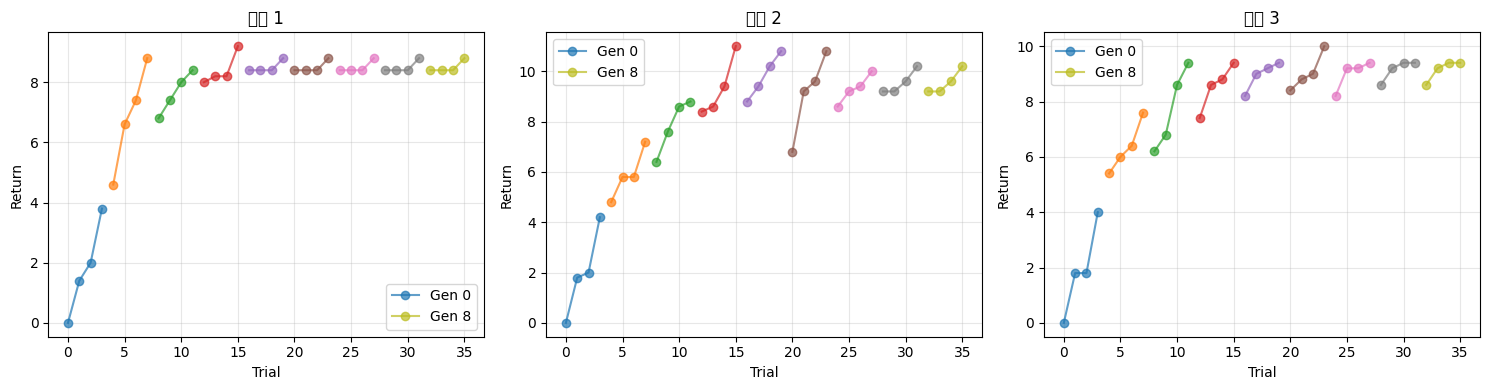


最终generation平均表现:
  条件 1: 8.50 ± 0.61
  条件 2: 9.55 ± 0.86
  条件 3: 9.15 ± 0.86


In [45]:
# 完整的多轨迹渐进学习评估 - 修复版
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

# 设置变量
num_types = 3
num_trials = 4
max_trial_len = 24
popsize = 3
num_seeds = 5
num_max_lens = all_outs[1].shape[1]

config = {
    "LR": 2.5e-4, "NUM_ENVS": 16, "NUM_STEPS": 128, "TOTAL_TIMESTEPS": 8e6,
    "UPDATE_EPOCHS": 2, "NUM_MINIBATCHES": 8, "GAMMA": 0.99, "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2, "ENT_COEF": 0.03, "VF_COEF": 0.5, "MAX_GRAD_NORM": 0.5,
    "ANNEAL_LR": True, "DEBUG": False, "CONTINUOUS": False, "UPDATE_VIS_PROB": False,
}

init_rng = jax.random.PRNGKey(420)
init_env = MetaMemSeq(num_types=num_types, init_rng=init_rng, num_trials=num_trials,
                      max_trial_len=max_trial_len, num_agents=popsize, other_probs=jnp.zeros((popsize,)))
network = ActorCriticRNN(num_types, config=config)
env = MetaMemSeq(num_types=num_types, other_network=network, init_rng=init_rng,
                 num_trials=num_trials, max_trial_len=max_trial_len, num_agents=popsize)
init_env_params = EnvParams()

def init_eval_fixed(rng, params, env_params):
    rng, _rng = jax.random.split(rng)
    last_obs, env_state = init_env.reset(_rng, env_params)
    init_state = ScannedRNN.initialize_carry(1, 256)
    
    def _env_step(runner_state, unused):
        prev_env_state, env_params, last_obs, last_done, prev_hstate, rng, ever_done, running_r, running_hstates, running_obss = runner_state
        rng, _rng = jax.random.split(rng)
        ac_in = (last_obs[None, None, :], last_done[None, None])
        hstate, pi, value = network.apply(params, prev_hstate, ac_in)
        action = pi.sample(seed=_rng).squeeze(0).squeeze(0)
        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = init_env.step(_rng, prev_env_state, action, env_params)
        temp_r = running_r[prev_env_state.trial_num] + (reward >= 0.0) * (1.0 - ever_done)
        running_r = running_r.at[prev_env_state.trial_num].set(temp_r)
        trial_idx = prev_env_state.trial_num
        replace_hstate = jnp.logical_and((prev_env_state.trial_num == trial_idx), ~ever_done)
        running_hstates = running_hstates.at[trial_idx].set(running_hstates[trial_idx] * (1.0 - replace_hstate) + hstate * replace_hstate)
        running_obss = running_obss.at[trial_idx].set(running_obss[trial_idx] * (1.0 - replace_hstate) + obsv * replace_hstate)
        ever_done = jnp.logical_or(done, ever_done)
        transition = (env_state, action, reward, running_r, running_hstates, running_obss)
        runner_state = (env_state, env_params, obsv, done, hstate, rng, ever_done, running_r, running_hstates, running_obss)
        return runner_state, transition
    
    running_hstates = jnp.stack([init_state] * num_trials)
    running_obss = jnp.stack([last_obs] * num_trials)
    runner_state = (env_state, env_params, last_obs, False, init_state, rng, False, jnp.zeros((num_trials,)), running_hstates, running_obss)
    runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, max_trial_len*num_trials+1)
    return traj_batch

def eval_fixed(rng, params, env_params):
    rng, _rng = jax.random.split(rng)
    last_obs, env_state = env.reset(_rng, env_params)
    init_state = ScannedRNN.initialize_carry(1, 256)
    
    def _env_step(runner_state, unused):
        prev_env_state, env_params, last_obs, last_done, prev_hstate, rng, ever_done, running_r, running_hstates, running_obss = runner_state
        rng, _rng = jax.random.split(rng)
        ac_in = (last_obs[None, None, :], last_done[None, None])
        hstate, pi, value = network.apply(params, prev_hstate, ac_in)
        action = pi.sample(seed=_rng).squeeze(0).squeeze(0)
        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, prev_env_state, action, env_params)
        temp_r = running_r[prev_env_state.trial_num] + (reward >= 0.0) * (1.0 - ever_done)
        running_r = running_r.at[prev_env_state.trial_num].set(temp_r)
        trial_idx = prev_env_state.trial_num
        replace_hstate = jnp.logical_and((prev_env_state.trial_num == trial_idx), ~ever_done)
        running_hstates = running_hstates.at[trial_idx].set(running_hstates[trial_idx] * (1.0 - replace_hstate) + hstate * replace_hstate)
        running_obss = running_obss.at[trial_idx].set(running_obss[trial_idx] * (1.0 - replace_hstate) + obsv * replace_hstate)
        ever_done = jnp.logical_or(done, ever_done)
        transition = (env_state, action, reward, running_r, running_hstates, running_obss)
        runner_state = (env_state, env_params, obsv, done, hstate, rng, ever_done, running_r, running_hstates, running_obss)
        return runner_state, transition
    
    running_hstates = jnp.stack([init_state] * num_trials)
    running_obss = jnp.stack([last_obs] * num_trials)
    runner_state = (env_state, env_params, last_obs, False, init_state, rng, False, jnp.zeros((num_trials,)), running_hstates, running_obss)
    runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, max_trial_len*num_trials+1)
    return traj_batch

print(f"开始评估 ({num_seeds} seeds × {num_max_lens} 条件)...\n")
test_all_trial_scores = []

for k in range(num_seeds):
    all_trial_scores = []
    for i in range(num_max_lens):
        print(f"Seed {k}, 条件 {i+1}/{num_max_lens}")
        rng = jax.random.PRNGKey(12)
        test = jax.jit(jax.vmap(init_eval_fixed, in_axes=(0, None, None)))
        other_params = jax.tree.map(lambda x: x[k,i], all_outs[0][0].params)
        infos = test(jax.random.split(rng, popsize), other_params, init_env_params)
        num_generations = 8
        trial_scores = []
        for j in range(num_generations):
            trial_scores_all = infos[-3][:,-1,:]
            best_agent_idx = jnp.argmax(trial_scores_all.mean(axis=1))
            sorted_trial_indices = jnp.argsort(trial_scores_all[best_agent_idx])
            saved_scores = trial_scores_all[best_agent_idx][sorted_trial_indices]
            saved_states = infos[-2][best_agent_idx, -1, sorted_trial_indices][:popsize]
            saved_obs = infos[-1][best_agent_idx, -1, sorted_trial_indices][:popsize]
            trial_scores.append(saved_scores)
            print(f"  Gen {j}: {saved_scores}")
            env_params = EnvParams(other_params=other_params, other_init_state=saved_states, other_init_last_obs=saved_obs)
            rng = jax.random.PRNGKey(3)
            test = jax.jit(jax.vmap(eval_fixed, in_axes=(0, None, None)))
            infos = test(jax.random.split(rng, popsize), other_params, env_params)
        trial_scores.append(saved_scores)
        all_trial_scores.append(np.array(trial_scores))
    test_all_trial_scores.append(np.array(all_trial_scores))

print(f"\n完成!生成可视化...\n")
fig, axes = plt.subplots(1, num_max_lens, figsize=(5*num_max_lens, 4))
if num_max_lens == 1:
    axes = [axes]
for max_len_idx in range(num_max_lens):
    ax = axes[max_len_idx]
    all_seeds_data = np.array([test_all_trial_scores[seed_idx][max_len_idx] for seed_idx in range(num_seeds)])
    mean_data = all_seeds_data.mean(axis=0)
    for gen_idx in range(mean_data.shape[0]):
        x_positions = np.arange(4) + gen_idx * 4
        ax.plot(x_positions, mean_data[gen_idx], 'o-', alpha=0.7, label=f'Gen {gen_idx}' if gen_idx in [0, mean_data.shape[0]-1] else '')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Return')
    ax.set_title(f'条件 {max_len_idx+1}')
    ax.grid(True, alpha=0.3)
    ax.legend()
plt.tight_layout()
plt.show()

print("\n最终generation平均表现:")
for max_len_idx in range(num_max_lens):
    final_gen_data = [np.mean(test_all_trial_scores[seed_idx][max_len_idx][-1]) for seed_idx in range(num_seeds)]
    print(f"  条件 {max_len_idx+1}: {np.mean(final_gen_data):.2f} ± {np.std(final_gen_data):.2f}")

运行Baseline:只选最优demo...

Baseline - Seed 0, 条件 1/3
  Gen 0: 最优=4.00, 平均=1.75
  Gen 1: 最优=7.00, 平均=6.00
  Gen 2: 最优=6.00, 平均=4.75
  Gen 3: 最优=7.00, 平均=6.00
  Gen 4: 最优=7.00, 平均=6.25
  Gen 5: 最优=9.00, 平均=5.75
  Gen 6: 最优=11.00, 平均=8.25
  Gen 7: 最优=5.00, 平均=3.25
Baseline - Seed 0, 条件 2/3
  Gen 0: 最优=4.00, 平均=2.00
  Gen 1: 最优=8.00, 平均=4.25
  Gen 2: 最优=6.00, 平均=4.25
  Gen 3: 最优=8.00, 平均=7.25
  Gen 4: 最优=4.00, 平均=2.75
  Gen 5: 最优=8.00, 平均=7.25
  Gen 6: 最优=10.00, 平均=8.75
  Gen 7: 最优=10.00, 平均=9.50
Baseline - Seed 0, 条件 3/3
  Gen 0: 最优=4.00, 平均=2.00
  Gen 1: 最优=6.00, 平均=4.75
  Gen 2: 最优=9.00, 平均=6.75
  Gen 3: 最优=4.00, 平均=1.75
  Gen 4: 最优=4.00, 平均=1.75
  Gen 5: 最优=4.00, 平均=1.75
  Gen 6: 最优=4.00, 平均=1.75
  Gen 7: 最优=4.00, 平均=1.75
Baseline - Seed 1, 条件 1/3
  Gen 0: 最优=2.00, 平均=1.25
  Gen 1: 最优=8.00, 平均=6.50
  Gen 2: 最优=8.00, 平均=8.00
  Gen 3: 最优=8.00, 平均=7.00
  Gen 4: 最优=8.00, 平均=8.00
  Gen 5: 最优=8.00, 平均=7.00
  Gen 6: 最优=8.00, 平均=8.00
  Gen 7: 最优=8.00, 平均=7.00
Baseline - Seed 1, 条件 2/3
  Gen 0: 最优

/tmp/ipykernel_64356/1275572764.py:98: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64356/1275572764.py:98: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64356/1275572764.py:98: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64356/1275572764.py:98: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64356/1275572764.py:98: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64356/1275572764.py:98: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64356/1275572764.py:98: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAP

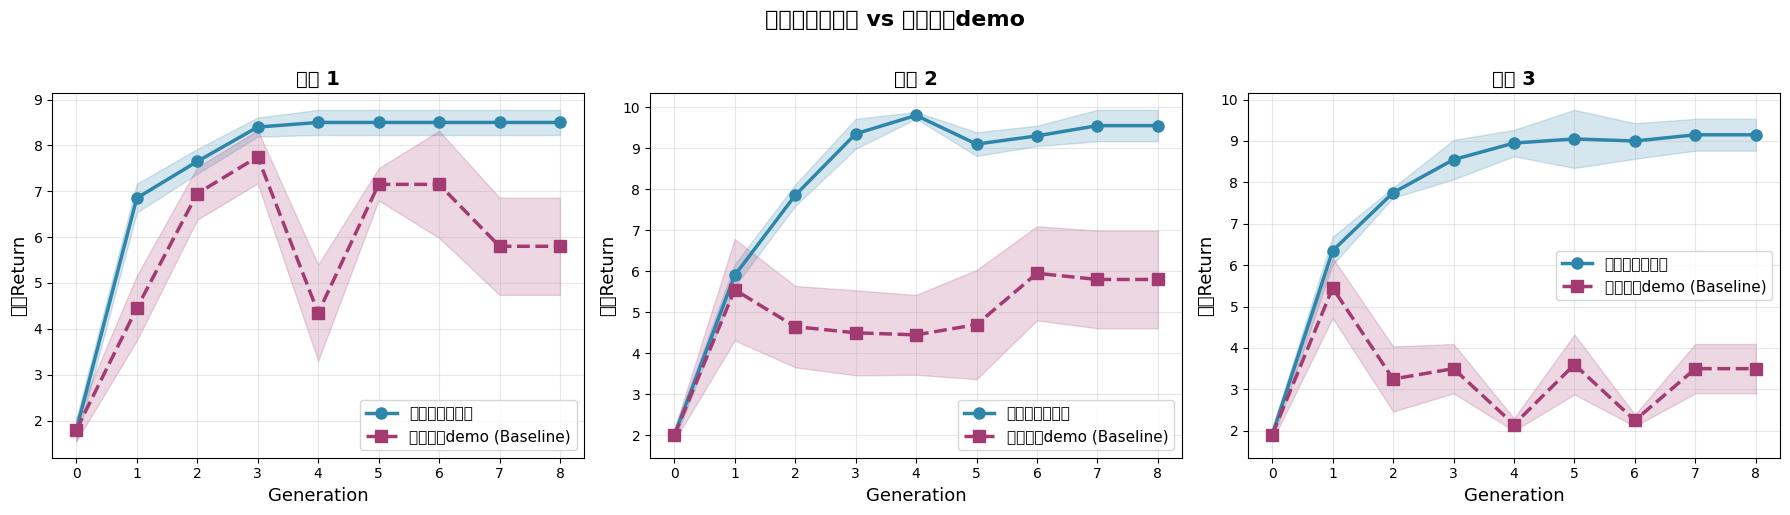


=== 对比统计 ===

条件 1:
  只选最优demo (Baseline): 5.80
  多轨迹渐进学习: 8.50
  改进: +2.70 (+46.6%)
  ✓ 多轨迹渐进学习更好!

条件 2:
  只选最优demo (Baseline): 5.80
  多轨迹渐进学习: 9.55
  改进: +3.75 (+64.7%)
  ✓ 多轨迹渐进学习更好!

条件 3:
  只选最优demo (Baseline): 3.50
  多轨迹渐进学习: 9.15
  改进: +5.65 (+161.4%)
  ✓ 多轨迹渐进学习更好!


In [46]:
# 对比:只选最优demo vs 多轨迹渐进学习
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

print("运行Baseline:只选最优demo...\n")

# Baseline:只选最优demo(传统方法)
baseline_scores = []
for k in range(num_seeds):
    all_trial_scores = []
    for i in range(num_max_lens):
        print(f"Baseline - Seed {k}, 条件 {i+1}/{num_max_lens}")
        rng = jax.random.PRNGKey(12)
        test = jax.jit(jax.vmap(init_eval_fixed, in_axes=(0, None, None)))
        other_params = jax.tree.map(lambda x: x[k,i], all_outs[0][0].params)
        infos = test(jax.random.split(rng, popsize), other_params, init_env_params)
        
        num_generations = 8
        trial_scores = []
        for j in range(num_generations):
            trial_scores_all = infos[-3][:,-1,:]
            best_agent_idx = jnp.argmax(trial_scores_all.mean(axis=1))
            
            # Baseline:只选最好的trial
            best_trial_idx = jnp.argmax(trial_scores_all[best_agent_idx])
            saved_scores = trial_scores_all[best_agent_idx]
            saved_state = infos[-2][best_agent_idx, -1, best_trial_idx]
            saved_obs = infos[-1][best_agent_idx, -1, best_trial_idx]
            
            # 所有agents使用相同的最优demo
            saved_states = jnp.stack([saved_state] * popsize)
            saved_obss = jnp.stack([saved_obs] * popsize)
            
            trial_scores.append(saved_scores)
            print(f"  Gen {j}: 最优={saved_scores[best_trial_idx]:.2f}, 平均={saved_scores.mean():.2f}")
            
            env_params = EnvParams(other_params=other_params, other_init_state=saved_states, other_init_last_obs=saved_obss)
            rng = jax.random.PRNGKey(3)
            test = jax.jit(jax.vmap(eval_fixed, in_axes=(0, None, None)))
            infos = test(jax.random.split(rng, popsize), other_params, env_params)
        
        trial_scores.append(saved_scores)
        all_trial_scores.append(np.array(trial_scores))
    baseline_scores.append(np.array(all_trial_scores))

# 生成对比图
print("\n生成对比图...\n")
fig, axes = plt.subplots(1, num_max_lens, figsize=(6*num_max_lens, 5))
if num_max_lens == 1:
    axes = [axes]

for max_len_idx in range(num_max_lens):
    ax = axes[max_len_idx]
    
    # 多轨迹渐进学习
    progressive_data = np.array([test_all_trial_scores[seed_idx][max_len_idx] for seed_idx in range(num_seeds)])
    progressive_means = []
    progressive_stds = []
    for gen_idx in range(progressive_data.shape[1]):
        gen_data = progressive_data[:, gen_idx, :].mean(axis=1)
        progressive_means.append(gen_data.mean())
        progressive_stds.append(gen_data.std() / np.sqrt(num_seeds))
    
    # Baseline:只选最优demo
    baseline_data = np.array([baseline_scores[seed_idx][max_len_idx] for seed_idx in range(num_seeds)])
    baseline_means = []
    baseline_stds = []
    for gen_idx in range(baseline_data.shape[1]):
        gen_data = baseline_data[:, gen_idx, :].mean(axis=1)
        baseline_means.append(gen_data.mean())
        baseline_stds.append(gen_data.std() / np.sqrt(num_seeds))
    
    progressive_means = np.array(progressive_means)
    progressive_stds = np.array(progressive_stds)
    baseline_means = np.array(baseline_means)
    baseline_stds = np.array(baseline_stds)
    
    # 绘制对比
    ax.plot(range(len(progressive_means)), progressive_means, 'o-', label='多轨迹渐进学习', 
            linewidth=2.5, markersize=8, color='#2E86AB')
    ax.fill_between(range(len(progressive_means)), progressive_means - progressive_stds, 
                     progressive_means + progressive_stds, alpha=0.2, color='#2E86AB')
    
    ax.plot(range(len(baseline_means)), baseline_means, 's--', label='只选最优demo (Baseline)', 
            linewidth=2.5, markersize=8, color='#A23B72')
    ax.fill_between(range(len(baseline_means)), baseline_means - baseline_stds, 
                     baseline_means + baseline_stds, alpha=0.2, color='#A23B72')
    
    ax.set_xlabel('Generation', fontsize=13)
    ax.set_ylabel('平均Return', fontsize=13)
    ax.set_title(f'条件 {max_len_idx+1}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle('多轨迹渐进学习 vs 只选最优demo', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 打印对比统计
print("\n=== 对比统计 ===")
for max_len_idx in range(num_max_lens):
    progressive_data = np.array([test_all_trial_scores[seed_idx][max_len_idx] for seed_idx in range(num_seeds)])
    baseline_data = np.array([baseline_scores[seed_idx][max_len_idx] for seed_idx in range(num_seeds)])
    
    prog_final = progressive_data[:, -1, :].mean()
    base_final = baseline_data[:, -1, :].mean()
    improvement = prog_final - base_final
    improvement_pct = (improvement / base_final) * 100 if base_final > 0 else 0
    
    print(f"\n条件 {max_len_idx+1}:")
    print(f"  只选最优demo (Baseline): {base_final:.2f}")
    print(f"  多轨迹渐进学习: {prog_final:.2f}")
    print(f"  改进: +{improvement:.2f} ({improvement_pct:+.1f}%)")
    
    if improvement > 0:
        print(f"  ✓ 多轨迹渐进学习更好!")
    elif improvement < 0:
        print(f"  ✗ Baseline更好")
    else:
        print(f"  = 两者相当")